# Library imports and parameters

In [106]:
import time, os, sys, shutil, pathlib, random, math

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import Audio
from google.colab import drive
from pathlib import Path

AUTOTUNE = tf.data.AUTOTUNE
seed = 69
tf.random.set_seed(seed)
np.random.seed(seed)

#Parameters
add_noise_bool = True
desired_snr = 10 #Deisred SNR(Signal to Noise Ratio) for the noise to be added
gdrive_path = Path("/content/gdrive/MyDrive/") / ("MSWC_dataset_wavs/MSWC_keywords_wavs.zip") #Path to the dataset with wav files consisting of the selected keywords(located in googleDrive)

sampleRate = 16000
sampleSegment = 256
sampleHop = 128
nfftSize = sampleSegment
windowSpec = sc.signal.windows.hann(sampleSegment)

EPOCHS = 110

convNetName = ("V0.01_simpleCNN_Spectro_SNR" + str(desired_snr) + "_MSWC")

In [2]:
from psutil import virtual_memory

device_name = tf.test.gpu_device_name()
print(device_name)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime, go to Runtime -> Change runtime type -> Runtime shape -> High-Ram')
  print("High ram is not strictly neccesary")
else:
  print('You are using a high-RAM runtime!')

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found(Training will be slower), to enable: go to Runtime -> Change runtime type -> Hardware accelerator: GPU')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Your runtime has 27.3 gigabytes of available RAM
You are using a high-RAM runtime!
Found GPU at: /device:GPU:0


Download needed (dataset) files


In [60]:
#shutil.rmtree("/content/dataset")
try: 
  drive.mount('/content/gdrive', force_remount=False)
  print("Google Drive succes!")
except:
  print("Error")

datasetPath = Path("/content/dataset")
os.mkdir(datasetPath)
shutil.unpack_archive(gdrive_path, datasetPath, "zip")
print("Dataset unpacked from Gdrive and placed in: ", datasetPath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive succes!
Dataset unpacked from Gdrive and placed in:  /content/dataset


Declaration of helper functions

In [102]:
def get_commands(ds_path):
  commands_dirs = os.listdir((ds_path / "TRAIN"))
  print(commands_dirs)
  return commands_dirs

def load_filenames(commands, set):
  filenames = []
  for item in commands:
    filenames = filenames + tf.io.gfile.glob(str(datasetPath / set / item) + "/*")
  print(len(filenames))
  shuffled_filnames = tf.random.shuffle(filenames)
  return shuffled_filnames

def decode_audio(encoded_audio):
  decoded_audio, _ = tf.audio.decode_wav(contents=encoded_audio)
  decoded_audio = tf.squeeze(decoded_audio, axis=-1)

  decoded_audio = decoded_audio[:sampleRate]
  zero_padding = tf.zeros([sampleRate] - tf.shape(decoded_audio), dtype=tf.float32)
  decoded_audio = tf.cast(decoded_audio, dtype=tf.float32)
  equal_length_audio = tf.concat([decoded_audio, zero_padding], 0)
  return equal_length_audio

def listenAudio(audio):
  display.display(display.Audio(audio, rate=16000))

def add_noise_to_audio(clean_audio):
  signal_watts = clean_audio ** 2
  signal_avg_watts = tf.math.reduce_mean(signal_watts)
  signal_avg_db = 10 * tf.math.log(signal_avg_watts)

  noise_avg_db = signal_avg_db - desired_snr
  noise_avg_watts = 10 ** (noise_avg_db / 10)
  mean_noise = 0
  noise_volts = tf.random.normal(shape=[len(signal_watts)], stddev=tf.math.sqrt(noise_avg_watts), dtype=tf.float32)

  noised_audio = clean_audio + noise_volts
  return noised_audio

def __spectrogram__(audio):
  _, _, spectrogram = sc.signal.spectrogram(audio, fs=sampleRate, nperseg=sampleSegment, noverlap=sampleHop, 
                                      nfft=nfftSize, mode="magnitude", window=windowSpec)
  return spectrogram

def get_spectrogram(audio):
  #x_shape = math.ceil((sampleRate - sampleSegment) / (sampleHop*sampleRate)+1)
  #y_shape = 
  spectrogram = tf.py_function(__spectrogram__, [audio], tf.float32)
  spectrogram = tf.expand_dims(spectrogram, -1)
  spectrogram.set_shape((129 , 124, 1))
  #_, _, spectrogram = tf.py_function(func=sc.signal.spectrogram, inp=[audio, sampleRate, windowSpec, sampleSegment, sampleHop, nfftSize, 'constant', True, 'density', -1, 'magnitude'], Tout=tf.float32)
  #_, _, spectrogram = sc.signal.spectrogram(audio, fs=sampleRate, nperseg=samplesSegment, noverlap=sampleHop, 
                                      #nfft=nfftSize, mode="magnitude", window=windowSpec)
  return spectrogram

def plot_spectrogram(spectrogram):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  plt.pcolormesh(spectrogram)
  plt.ylabel("Frequency")
  plt.xlabel("Time")
  plt.show()
  return

def get_label_from_path(filePath):
  splitPath = tf.strings.split(filePath, os.path.sep)
  label = splitPath[-2]
  set = splitPath[-3]
  return label, set

def get_label_id(label):
  print(label)
  label_id = tf.argmax(label == commands)
  return label_id

def wav_preProcessing(filePath, add_noise_bool):
  label, set = get_label_from_path(filePath)
  label_id = get_label_id(label)

  audio_binary = tf.io.read_file(filePath)
  waveform = decode_audio(audio_binary)
  if add_noise_bool == True and random.randrange(2) == 1:
    waveform = add_noise_to_audio(waveform)
  
  spectrogram = get_spectrogram(waveform)
  return spectrogram, label_id

def ds_preProcessing(set, add_noise_bool):
  allFiles = load_filenames(commands, set)
  print(allFiles)
  files_ds = tf.data.Dataset.from_tensor_slices(allFiles)
  output_ds = files_ds.map(
      map_func=(lambda file_path: wav_preProcessing(file_path, add_noise_bool)),
      num_parallel_calls=AUTOTUNE)
  return output_ds

itteration = 0
commands = get_commands(datasetPath)
allTestFiles = load_filenames(commands, "TRAIN")
print(commands)
for path in allTestFiles:
  print(path)
  label_name, set_name = get_label_from_path(path)
  print("Label name is : ", label_name, "Set  name is: ", set_name)
  print("Label id is: ", get_label_id(label_name).numpy())
  print()
  if itteration == 5: sys.exit()
  itteration += 1

['blue', 'red', 'unknown']
7895
['blue', 'red', 'unknown']
tf.Tensor(b'/content/dataset/TRAIN/unknown/common_voice_nl_21105144.wav', shape=(), dtype=string)
Label name is :  tf.Tensor(b'unknown', shape=(), dtype=string) Set  name is:  tf.Tensor(b'TRAIN', shape=(), dtype=string)
tf.Tensor(b'unknown', shape=(), dtype=string)
Label id is:  2

tf.Tensor(b'/content/dataset/TRAIN/blue/common_voice_en_19641251.wav', shape=(), dtype=string)
Label name is :  tf.Tensor(b'blue', shape=(), dtype=string) Set  name is:  tf.Tensor(b'TRAIN', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
Label id is:  0

tf.Tensor(b'/content/dataset/TRAIN/blue/common_voice_en_21094474.wav', shape=(), dtype=string)
Label name is :  tf.Tensor(b'blue', shape=(), dtype=string) Set  name is:  tf.Tensor(b'TRAIN', shape=(), dtype=string)
tf.Tensor(b'blue', shape=(), dtype=string)
Label id is:  0

tf.Tensor(b'/content/dataset/TRAIN/red/common_voice_en_20495662.wav', shape=(), dtype=string)
Label name is : 

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


['blue', 'red', 'unknown']
7895
tf.Tensor(
[b'/content/dataset/TRAIN/unknown/common_voice_nl_17985591.wav'
 b'/content/dataset/TRAIN/red/common_voice_en_215161.wav'
 b'/content/dataset/TRAIN/blue/common_voice_en_66580.wav' ...
 b'/content/dataset/TRAIN/blue/common_voice_en_112593.wav'
 b'/content/dataset/TRAIN/blue/common_voice_en_550392.wav'
 b'/content/dataset/TRAIN/red/common_voice_en_20125918.wav'], shape=(7895,), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)
1003
tf.Tensor(
[b'/content/dataset/TEST/red/common_voice_en_188733.wav'
 b'/content/dataset/TEST/blue/common_voice_en_17296496.wav'
 b'/content/dataset/TEST/unknown/common_voice_nl_18819875.wav' ...
 b'/content/dataset/TEST/unknown/common_voice_nl_20218807.wav'
 b'/content/dataset/TEST/red/common_voice_en_19718577.wav'
 b'/content/dataset/TEST/blue/common_voice_en_19577621.wav'], shape=(1003,), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)
1003
tf.Tensor(
[b'/content/dataset/DEV/red/common_

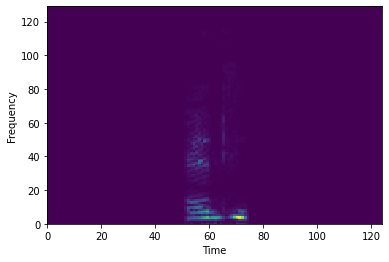

Minimum spectrogram tf.Tensor(2.5999602e-12, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.0018818992, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


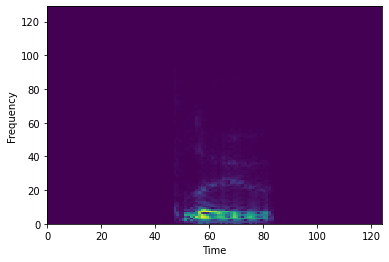

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.0012172103, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


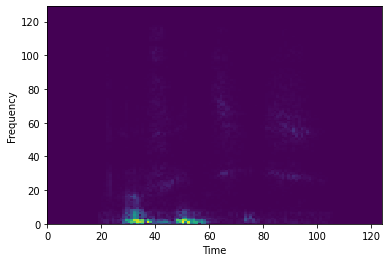

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.004445316, shape=(), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)


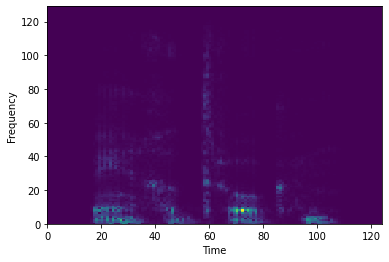

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.0007876217, shape=(), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)


In [103]:
#shutil.rmtree("/content/dataset/DEV/unknown")
#shutil.rmtree("/content/dataset/TRAIN/unknown")
#shutil.rmtree("/content/dataset/TEST/unknown")

commands = get_commands(datasetPath)
train_ds = ds_preProcessing("TRAIN", add_noise_bool)
val_ds = ds_preProcessing("TEST", add_noise_bool)
test_ds = ds_preProcessing("DEV", add_noise_bool)

print(train_ds)

for spectrogram, label in val_ds.take(4):
  plot_spectrogram(spectrogram)
  print("Minimum spectrogram", tf.reduce_min(spectrogram), "Maximum spectrogram value:", tf.reduce_max(spectrogram))
  print(label)

Input shape: (129, 124, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)      

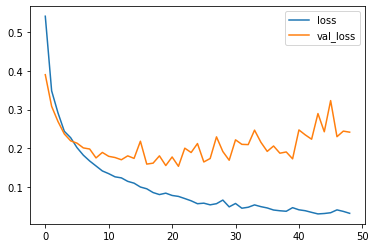

In [104]:
for spectrogram, _ in test_ds.take(1):
  input_shape = spectrogram.shape
  input_example = spectrogram
print('Input shape:', input_shape)
num_labels = len(commands)
#data=mfcc_ds.map(lambda mfcc, label: 
                 #tf.py_function(func=(lambda spec, label: spec), inp=(mfcc, label_id), Tout=(tf.float32, tf.int64)))
#data = spectrogram
  #output_ds = files_ds.map(lambda file_path: tf.py_function(func=get_waveform_and_label, inp=(file_path, True), Tout=(tf.float32, tf.string)))
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
mobileNet = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

mobileNet.summary()

print("Number of commands and ending parameters: ", len(commands))
mobileNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

with tf.device('/device:GPU:0'):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=5)
  history = mobileNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[callback], verbose=2
)
  
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Input shape: (257, 61, 1)
Number of commands and ending parameters:  3
Epoch 1/15
124/124 - 84s - loss: 0.6322 - accuracy: 0.7463 - val_loss: 1.2755 - val_accuracy: 0.2981 - 84s/epoch - 678ms/step
Epoch 2/15
124/124 - 13s - loss: 0.3726 - accuracy: 0.8595 - val_loss: 1.2597 - val_accuracy: 0.2981 - 13s/epoch - 106ms/step
Epoch 3/15
124/124 - 13s - loss: 0.2707 - accuracy: 0.8998 - val_loss: 1.2570 - val_accuracy: 0.3330 - 13s/epoch - 105ms/step
Epoch 4/15
124/124 - 13s - loss: 0.2184 - accuracy: 0.9215 - val_loss: 1.6951 - val_accuracy: 0.3330 - 13s/epoch - 107ms/step
Epoch 5/15
124/124 - 13s - loss: 0.2003 - accuracy: 0.9279 - val_loss: 1.7909 - val_accuracy: 0.3330 - 13s/epoch - 106ms/step
Epoch 6/15
124/124 - 13s - loss: 0.1648 - accuracy: 0.9369 - val_loss: 0.9426 - val_accuracy: 0.6281 - 13s/epoch - 106ms/step
Epoch 7/15
124/124 - 13s - loss: 0.1513 - accuracy: 0.9430 - val_loss: 0.8229 - val_accuracy: 0.7737 - 13s/epoch - 107ms/step
Epoch 8/15
124/124 - 13s - loss: 0.1386 - accur

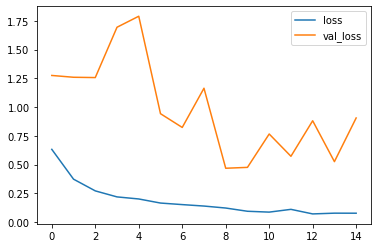

In [95]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

print("Number of commands and ending parameters: ", len(commands))
mobileNet = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape,
                                    classes=num_labels, weights=None)
mobileNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

with tf.device('/device:GPU:0'):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=5)
  history = mobileNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[callback], verbose=2
)
  
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [52]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

def top_3_accuracy(x, y): 
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(x,y,3)
def create_model():
    modelTest = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                    classes=num_labels, include_preprocessing=False,
                                    minimalistic=False, alpha=1.0, weights=None)
   
    opt = tf.keras.optimizers.Adam()

    modelTest.compile(optimizer=opt, 
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.sparse_categorical_accuracy, top_3_accuracy])
    modelTest.summary()
    return modelTest
mobileNet = create_model()

Input shape: (129, 124, 1)
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 129, 124, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 65, 62, 16)   144         ['input_9[0][0]']                
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 65, 62, 16)  64          ['Conv[0][0]']                   
 tion)                                                                                            
                                                        

In [53]:
weight_path="{}_weights.best.hdf5".format('mfcc_sound_modelV3s')
checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, patience=5, 
                                   verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, 
                                   min_lr=0.00001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [54]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [55]:
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'):
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=5)
    history = mobileNet.fit(
      train_ds, batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[callbacks_list],
      epochs=EPOCHS, verbose=2)
else:
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=5)
  history = mobileNet.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS, verbose=2)

Epoch 1/110

Epoch 00001: val_loss improved from inf to 0.69104, saving model to mfcc_sound_modelV3s_weights.best.hdf5
84/84 - 17s - loss: 0.3152 - sparse_categorical_accuracy: 0.8606 - top_3_accuracy: 1.0000 - val_loss: 0.6910 - val_sparse_categorical_accuracy: 0.5531 - val_top_3_accuracy: 1.0000 - lr: 0.0010 - 17s/epoch - 207ms/step
Epoch 2/110

Epoch 00002: val_loss improved from 0.69104 to 0.68982, saving model to mfcc_sound_modelV3s_weights.best.hdf5
84/84 - 4s - loss: 0.1216 - sparse_categorical_accuracy: 0.9543 - top_3_accuracy: 1.0000 - val_loss: 0.6898 - val_sparse_categorical_accuracy: 0.5531 - val_top_3_accuracy: 1.0000 - lr: 0.0010 - 4s/epoch - 48ms/step
Epoch 3/110

Epoch 00003: val_loss improved from 0.68982 to 0.68947, saving model to mfcc_sound_modelV3s_weights.best.hdf5
84/84 - 4s - loss: 0.0872 - sparse_categorical_accuracy: 0.9672 - top_3_accuracy: 1.0000 - val_loss: 0.6895 - val_sparse_categorical_accuracy: 0.5531 - val_top_3_accuracy: 1.0000 - lr: 0.0010 - 4s/epoch

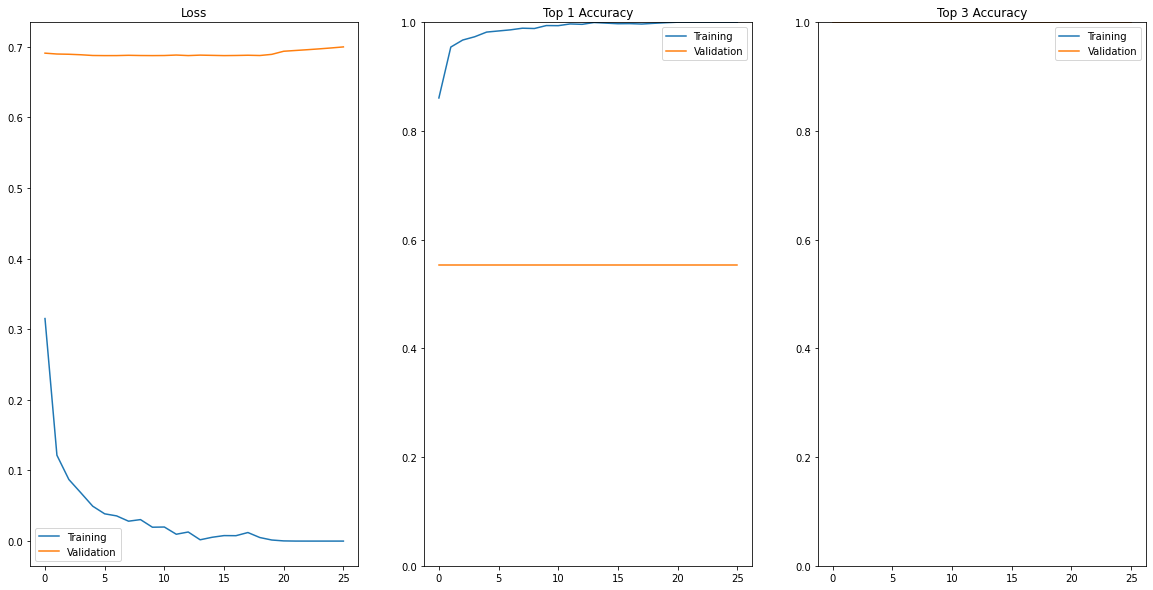

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(history.history['sparse_categorical_accuracy'], label='Training')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Top 1 Accuracy')
ax2.set_ylim(0, 1)
ax3.plot(history.history['top_3_accuracy'], label='Training')
ax3.plot(history.history['val_top_3_accuracy'], label='Validation')
ax3.legend()
ax3.set_title('Top 3 Accuracy')
ax3.set_ylim(0, 1);

(1003, 129, 124, 1)
(129, 124, 1)
Labels:  (1003,)
Test set accuracy: 95%


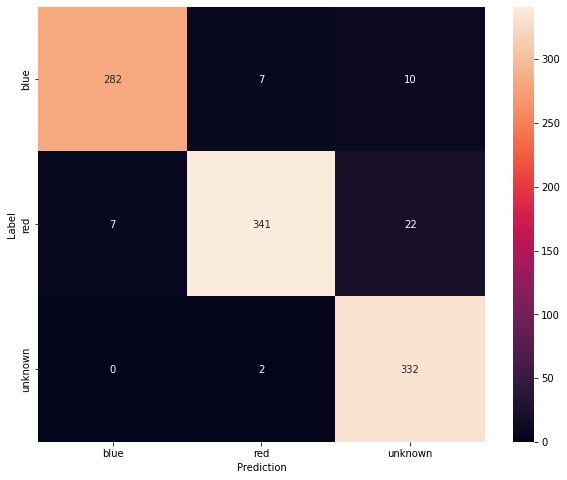

In [105]:
import seaborn as sns

test_spectrogram = []
test_labels = []

for spectrogram, label in test_ds:
  test_spectrogram.append(spectrogram.numpy())
  test_labels.append(label.numpy())

test_spectrogram = np.array(test_spectrogram)
test_labels = np.array(test_labels)

print(test_spectrogram.shape)
print(test_spectrogram.shape[1:])
y_pred = np.argmax(mobileNet.predict(test_spectrogram), axis=1)
y_true = test_labels
print("Labels: ", test_labels.shape)

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [115]:
try: 
  drive.mount('/content/gdrive', force_remount=False)
  print("Google Drive succes!")
except:
  print("Error")

usedKeywords = ""
for command in commands:
  usedKeywords = usedKeywords + "_" + str(command)

try:
  mobileNet.save(filepath='/content/gdrive/MyDrive/Saved_models/' + (convNetName + "_keywords" + usedKeywords), overwrite=False, save_format='tf')
except:
  print("Error")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive succes!
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Saved_models/V0.01_simpleCNN_Spectro_SNR10_MSWC_keywords_blue_red_unknown/assets


In [118]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/gdrive/MyDrive/Saved_models/' + (convNetName + "_keywords" + usedKeywords)) # path to the SavedModel directory
tflite_model = converter.convert()

tfLiteModel_name = (convNetName + "_keywords" + usedKeywords)
# Save the model.
with open(tfLiteModel_name, 'wb') as f:
  f.write(tflite_model)

shutil.copyfile(tfLiteModel_name, ('/content/gdrive/MyDrive/Saved_models/tfLite_models/' + tfLiteModel_name + ".tflite"))

'/content/gdrive/MyDrive/Saved_models/tfLite_models/V0.01_simpleCNN_Spectro_SNR10_MSWC_keywords_blue_red_unknown.tflite'